**UNINET : Modelo de Recomendaciones de Asignaturas para Estudiantes**

Universidad Metropolitana

Proyecto de Investigación de Ingeniería de Sistemas

Gilberto Pucciarelli y Vito Tatoli

## Imports

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import os 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dropout, Dense, Flatten, Activation, LSTM, Bidirectional, Concatenate, Embedding, Reshape, ConvLSTM2D, TimeDistributed, MaxPooling3D, BatchNormalization
from keras.models import Model

# Métrica de AUC
from sklearn.metrics import roc_auc_score

from IPython.display import HTML, display
import time
import json

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Cargar los Datos 

In [3]:
# Se cargan los datos del csv preprocesado anteriormente
df = pd.read_csv('/content/drive/MyDrive/Archivos/clean_data.csv', encoding='latin-1')

# Se eliminan las columnas de datos innecesarias  
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'SÃ­mbolo de notas', 'cuali'], axis=1)
df

,Plan de Estudios,C.I.,asignatura,trim,course,course_pre
0,CIENCIAS ADMINISTRATIVAS,18818660,BPTBC26,1,BPTBC26_Good,107
1,CIENCIAS ADMINISTRATIVAS,18818660,BPTFN06,1,BPTFN06_Excellent,489
2,CIENCIAS ADMINISTRATIVAS,18818660,FBTIE01,1,FBTIE01_Good,866
3,CIENCIAS ADMINISTRATIVAS,18314789,FBTIN04,1,FBTIN04_Good,878
4,CIENCIAS ADMINISTRATIVAS,18314789,FPTMK01,1,FPTMK01_Good,1727
...,...,...,...,...,...,...
425701,PSICOLOGÃA,84611414,FBTHU01,24,FBTHU01_Failed,853
425702,PSICOLOGÃA,84611414,FBTMM00,24,FBTMM00_Failed,901
425703,PSICOLOGÃA,84611414,FBTIE02,24,FBTIE02_Good,870
425704,PSICOLOGÃA,84611414,FBPIN02,24,FBPIN02_Good,796


## Diccionarios

In [4]:
# Contiene todos los valores de las asignaturas contenidas en los datos utilizadas
courses = df.course.values

# Se obtienen las posibilidades únicas de las materias junto con su calificación en los datos utilizados 
unique_courses = set(df.course.values)
unique_assigns = set(df.asignatura.values)
unique_est = set(df['C.I.'].values)

print(f'Unique courses: {len(unique_courses)}')
print(f'Unique assigns: {len(unique_assigns)}')
print(f'Unique estudents: {len(unique_est)}')

Unique courses: 1669
Unique assigns: 460
Unique estudents: 13163


In [5]:
# Se crean dos diccionarios: 
# 1. Uno donde las keys representan un número entero y el value es la asignatura junto con su calificación
# 2. Otro donde las keys representan un string de la asignatura con su calificación y el value es un número entero lo identifica

with open('/content/drive/MyDrive/Archivos/vocab_to_int.json') as f:
    vocab_to_int = json.load(f)

with open('/content/drive/MyDrive/Archivos/int_to_vocab.json') as f:
    int_to_vocab = json.load(f)

all_assigns = set(line.strip() for line in open('/content/drive/MyDrive/Archivos/only_assigns.txt'))

## Agrupar estudiantes y ordenar por trimestres

In [6]:
# Se agrupan por los estudiantes junto con los trimestres que cursó 
grouped = df.sort_values('trim').groupby(['C.I.'])

In [7]:
# Se obtiene un identificador para c/u de los estudiantes (su cédula)
ids = grouped['C.I.'].unique().values

# Se dividen los datos en dos conjuntos (train y test) en base al identificador anterior 
train_ids, test_ids = train_test_split(ids, test_size=0.05)

train = pd.DataFrame()
test = pd.DataFrame()
num=0

# Se construyen el DataFrame train y test en base a lo establecido anteriomente 
for iid in train_ids:
    train = train.append(df.loc[df['C.I.'] == iid[0]])

for iid in test_ids:
    test = test.append(df.loc[df['C.I.'] == iid[0]])

In [8]:
# Se agrupan los conjuntos de estudiantes con c/u de sus trimestres en base al conjunto de train y test 
grouped = train.sort_values('trim').groupby(['C.I.'])
grouped_test = test.sort_values('trim').groupby(['C.I.']) 

## Separando el data set

Se separa el dataset en train, dev y test. Luego, se crean las variables X, Y y O con las que se van a entrenar al modelo.

**Auxiliar para mostrar el avance**

In [9]:
# Función que permite mostrar el progreso de ejecución de los datos 

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

**Obtención del conjunto de entrenamiento**

*   Se obtienen dos conjuntos: X (historial del estudiante), y Y (materias a inscribir por el estudiante)

In [10]:
array_data = [] # Contiene el historial de trimestre de los estudiantes | dims: (estudiante, trimestre, materia)
array_trim = [] # Contiene cada uno de los trimestres vistos por todos los estudiantes en los datos utilizados | dims: (trimestre, materia)

# Se establece el número máximo de trimestres, con la finalidad de formar una matriz cuadrada de los datos 
max_number_trims = 24

# Se establece el número máximo de asignaturas que se pueden ver en un trimestre, con la finalidad de formar una matriz cuadrada de los datos 
max_number_assigns = 7

# Variables para el loader
out_estudiante = display(progress(0, len(grouped)), display_id=True)
i_estudiante = 0
out_trim = display(progress(0, len(grouped)), display_id=True)

# Se itera por cada uno de los estudiantes junto con los trimestres que cursó 
for est, est_group in grouped:
    cant_trim = est_group['trim'].unique()

    row_trim = []    
    
    # Variables para el loader
    i_estudiante += 1 
    out_estudiante.update(progress(i_estudiante, len(grouped))) 
    count = 0

    if len(cant_trim) != 1:     
        # Se itera por cada uno de los trimestres para obtener las materias que vió en cada uno de ellos 
        for trim in cant_trim:
            temp = df[(df['C.I.'] == est) & (df['trim'] == trim)]
            temp = temp[:7]
            row = []

            # Variables para el loader
            count += 1
            out_trim.update(progress(count, len(cant_trim)))

            # Se guardan las materias que curso en el trimestre
            for assign in temp['course'].unique():
                row.append(assign)
            
            # Como es una matriz cuadrada, se llenan las posiciones restantes con un número que 
            # representa un "espacio vacío" 
            for i in range(max_number_assigns - len(row)):
                row.append(len(vocab_to_int))
            
            # Se almacen los datos anteriores
            row_trim.append(row)
            array_trim.append(row)

        array_data.append(row_trim)

In [11]:
array_hist = [] # Contiene el histórico de los estudiantes sometidos a data augmentation
array_target = [] # Contiene las materias que el estudiante verá en su trimestre objetivo (próximo trimestre)

aux_array = [0] * max_number_assigns

sigm_target = []

# Variables para el loader
out_estudiante = display(progress(0, len(array_data)), display_id=True)
i_estudiante = 0

for est in range(len(array_data)):
    
    # Variables para el loader
    i_estudiante += 1 
    out_estudiante.update(progress(i_estudiante, len(array_data))) 
    count = 0

    # Auxiliar para ayudar a armar los arrays
    other_array = []
    for i in range(max_number_trims):
        other_array.append([len(vocab_to_int)] * max_number_assigns)
    
    # Validar que el estudiante tenga mas de un (1) trimestre visto 
    if len(array_data[est]) == 1: 
            continue
    else: 
        for trim in range(len(array_data[est])): 
            count = 0
            if trim != len(array_data[est]) - 1:

                other_array.pop(trim)
                other_array.insert(trim, array_data[est][trim].copy())
            
                array_hist.append(other_array.copy())

                array_target.append(array_data[est][trim + 1].copy())

In [12]:
array_target_output = []

all_assigns = sorted(all_assigns)

# Variables para el loader
out_estudiante = display(progress(0, len(array_target)), display_id=True)
i_estudiante = 0

for est in range(len(array_target)):
    
    # Variables para el loader
    i_estudiante += 1 
    out_estudiante.update(progress(i_estudiante, len(array_target))) 
    count = 0

    only_assigns = {}
    for assign_zero in all_assigns:
        only_assigns[assign_zero] = 0
    
    for assign in range(len(array_target[est])):
        if array_target[est][assign] != len(vocab_to_int):
            only_assigns[array_target[est][assign].split('_')[0]] = 1

    array_target_output.append(np.array(tuple(only_assigns.values())))

**Estableciendo el target para cada entrada**

Se crea un array de targets, en el que para cada row del array de trimestres objetivo (target): 

*   Se asigna 1 si se obtuvo una calificación buena (mayor o igual a 13) en todas las materias. 
*   Se asigna 0 si reprobó/retiró u obtuvo una nota menor a 13 en alguna materia.

In [13]:
# Se construye una matriz, de una sola columna, para cada uno de los estudiantes
sigm_target = np.zeros((len(array_target), 1), dtype=int)

# Si el estudiante no retiró o reprobó alguna de las materias en el trimestre, se cambia el valor de la columna a 1 
# Que indica que el estudiante obtuvo una calificació buena o mayor en todas las materias que cursó 
for i in range(len(array_target)):
    count = 0
    for j in range(len(array_target[i])):
        if array_target[i][j] != len(vocab_to_int) and (array_target[i][j].split('_')[1] == 'Withdraw' or array_target[i][j].split('_')[1] == 'Failed'): 
            count += 1

    if count == 0:
        sigm_target[i] = 1 


**Convertir las materias en los índices de la Embedding Matrix**

In [14]:
# Se convierte cada uno de los strings de materias en los índices, utilizando los diccionarios definidos anteriormente 
for i in range(len(array_hist)):
    for j in range(len(array_hist[i])):
        for k in range(len(array_hist[i][j])):
            if array_hist[i][j][k] != len(vocab_to_int) and str(array_hist[i][j][k]) not in int_to_vocab:
                array_hist[i][j][k] = vocab_to_int[array_hist[i][j][k]]

In [15]:
# Los arrays son del tipo 'list', se convierten a arrays númericos 
for i in range(len(array_hist)):
    for j in range(len(array_hist[i])):
        array_hist[i][j] = np.asarray(array_hist[i][j])
    array_hist[i] = np.asarray(array_hist[i])
    
for i in range(len(array_target_output)):
    array_target_output[i] = np.asarray(array_target_output[i])
    
array_hist = np.asarray(array_hist)
array_target_output = np.asarray(array_target_output)
sigm_target = np.asarray(sigm_target)

**Separando el conjunto de datos de entrenamiento en los conjuntos de train y dev** 

(para el entrenamiento y validación del modelo)

In [16]:
# Se separa el dataset en la proporción 80-20-20 para train, dev y test respectivamente
X_train, X_dev, Y_train, Y_dev, O_train, O_dev = train_test_split(array_hist, array_target_output, sigm_target, test_size=0.25)  # Sería el equivalente al 20% de toda la data
print(X_train.shape)
print(Y_train.shape)
print(O_train.shape)

print(X_dev.shape)
print(Y_dev.shape)
print(O_dev.shape)

(62535, 24, 7)
(62535, 466)
(62535, 1)
(20846, 24, 7)
(20846, 466)
(20846, 1)


**Se carga la Embedding Matrix**

In [17]:
# Se cargan los datos de la embedding matrix, obtenida en el word2vec 
embedding_matrix = np.genfromtxt('/content/drive/MyDrive/Archivos/embedding.csv', delimiter=',')
embedding_matrix.shape

(1903, 30)

**Se inserta una fila (todos valores 0) que representa los "espacios vacíos" de materias**

In [18]:
# Se crea una row o fila de puros ceros (0), que representa los 'espacios vacíos' definidos anteriormente 
all_zeros = np.zeros((30, ), dtype=int)

embedding_matrix = np.vstack((embedding_matrix, all_zeros))

## Definición del modelo

Se construye un modelo que recibe dos entradas, un array del histórico del estudiante (X) y otro del trimestre objetivo o target (Y), y un output tipo sigmoide que indica 1 si el estudiante pasará todas las materias, y 0 en caso contrario (O).

In [45]:
def model():
    
    # Se definen dos inputs #
    main_input = Input(shape=(max_number_trims, max_number_assigns, ), name='main_input')
    second_input = Input(shape=(len(all_assigns), ), name='second_input')

    # Se define la Embedding Layer con los valores que se obtuvieron del word2vec
    X = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(main_input)
    X = Reshape((max_number_trims, max_number_assigns, embedding_matrix.shape[1], 1))(X) 
 
    # Primera rama de la Red utiliza el primer input (main input) # 
    X = ConvLSTM2D(filters=10, kernel_size=(4, 5), strides=2, padding='valid', dropout=0.3, recurrent_dropout=0.1, return_sequences=True)(X)
    X = MaxPooling3D(pool_size=(2, 2, 2), padding='valid', strides=1)(X)

    X = TimeDistributed(Flatten())(X)
    X = LSTM(32, dropout=0.3, recurrent_dropout=0.1, return_sequences=False)(X)
    X = Dense(32, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(32, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(32, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(32, activation='relu')(X)

    # Segunda rama de la Red utiliza el segundo input (second input) #
    Y = Dense(32, activation='relu')(second_input)

    # Se combinan los outputs de las dos ramas #
    combined = Concatenate()([X, Y])
    main_output = Dense(1, activation='sigmoid', name='main_output')(combined)

    model = Model(inputs=[main_input, second_input], outputs=[main_output])

    # Compile the model # 
    model.compile(
        optimizer = 'adam', 
        loss = 'binary_crossentropy', 
        metrics = ['binary_accuracy']
    )
    
    history = model.fit([X_train, Y_train],  O_train, 
                        batch_size = 32, epochs = 5,
                        validation_data = ([X_dev, Y_dev], O_dev))
    
    print(model.summary())
    
    return (model, history)

In [46]:
model, history = model()

Epoch 1/5
1955/1955 [==============================] - 477s 240ms/step - loss: 0.6031 - binary_accuracy: 0.6631 - val_loss: 0.5478 - val_binary_accuracy: 0.7163
Epoch 2/5
1955/1955 [==============================] - 475s 243ms/step - loss: 0.5420 - binary_accuracy: 0.7189 - val_loss: 0.5339 - val_binary_accuracy: 0.7267
Epoch 3/5
1955/1955 [==============================] - 467s 239ms/step - loss: 0.5325 - binary_accuracy: 0.7269 - val_loss: 0.5313 - val_binary_accuracy: 0.7285
Epoch 4/5
1955/1955 [==============================] - 464s 237ms/step - loss: 0.5277 - binary_accuracy: 0.7298 - val_loss: 0.5266 - val_binary_accuracy: 0.7315
Epoch 5/5
1955/1955 [==============================] - 460s 236ms/step - loss: 0.5204 - binary_accuracy: 0.7349 - val_loss: 0.5316 - val_binary_accuracy: 0.7278
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to  

## Graficar modelo

In [47]:
import matplotlib.pyplot as plt

def graf_model(train_history):
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    # Summarize history for accuracy
    ax.plot(train_history.history['binary_accuracy'])
    ax.plot(train_history.history['val_binary_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    
    # Summarize history for loss
    ax2.plot(train_history.history['loss'])
    ax2.plot(train_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.show()

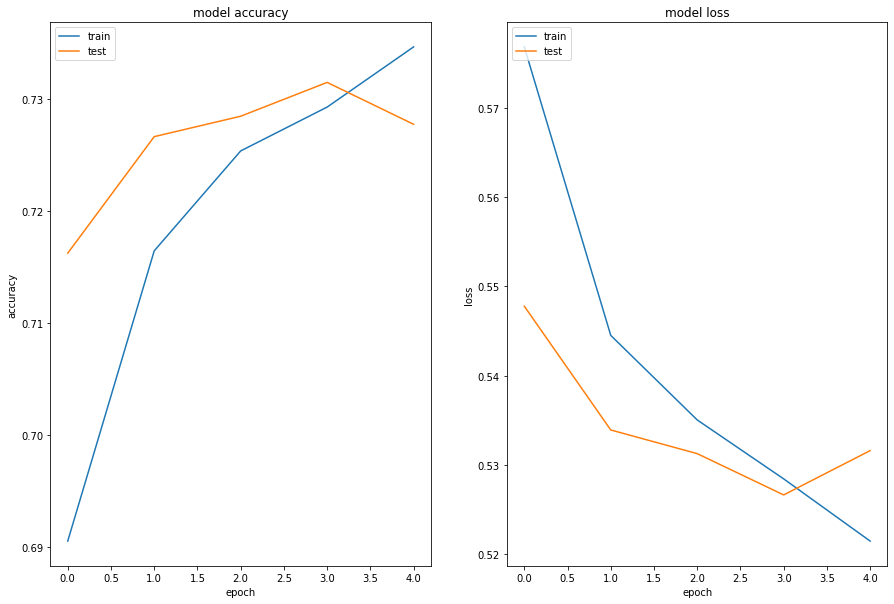

In [48]:
# Se grafica la precisión y loss del modelo empleado 
graf_model(history) 

In [65]:
# Save to file in the current working directory
model.save('model_final.h5')

## Test del modelo

In [71]:
array_data = [] # Contiene el historial de trimestre de los estudiantes | dims: (estudiante, trimestre, materia)
array_trim = [] # Contiene cada uno de los trimestres vistos por todos los estudiantes en los datos utilizados | dims: (trimestre, materia)

# Se establece el número máximo de trimestres, con la finalidad de formar una matriz cuadrada de los datos 
max_number_trims = 24

# Se establece el número máximo de asignaturas que se pueden ver en un trimestre, con la finalidad de formar una matriz cuadrada de los datos 
max_number_assigns = 7

# Variables para el loader
out_estudiante = display(progress(0, len(grouped_test)), display_id=True)
i_estudiante = 0
out_trim = display(progress(0, len(grouped_test)), display_id=True)

# Se itera por cada uno de los estudiantes junto con los trimestres que cursó 
for est, est_group in grouped_test:
    cant_trim = est_group['trim'].unique()

    row_trim = []    
    
    # Variables para el loader
    i_estudiante += 1 
    out_estudiante.update(progress(i_estudiante, len(grouped_test))) 
    count = 0

    if len(cant_trim) != 1:     
        # Se itera por cada uno de los trimestres para obtener las materias que vió en cada uno de ellos 
        for trim in cant_trim:
            temp = df[(df['C.I.'] == est) & (df['trim'] == trim)]
            temp = temp[:7]
            row = []

            # Variables para el loader
            count += 1
            out_trim.update(progress(count, len(cant_trim)))

            # Se guardan las materias que curso en el trimestre
            for assign in temp['course'].unique():
                row.append(assign)

            # Como es una matriz cuadrada, se llenan las posiciones restantes con un número que 
            # representa un "espacio vacío" 
            for i in range(max_number_assigns - len(row)):
                row.append(len(vocab_to_int))
            
            # Se almacen los datos anteriores
            row_trim.append(row)
            array_trim.append(row)

        array_data.append(row_trim)

In [72]:
array_target_output = []

all_assigns = sorted(all_assigns)

# Variables para el loader
out_estudiante = display(progress(0, len(array_data)), display_id=True)
i_estudiante = 0

for est in range(len(array_data)):
    
    # Variables para el loader
    i_estudiante += 1 
    out_estudiante.update(progress(i_estudiante, len(array_data))) 
    count = 0

    only_assigns = {}
    for assign_zero in all_assigns:
        only_assigns[assign_zero] = 0
    
    for assign in range(len(array_data[est][-1])):
        if array_data[est][-1][assign] != len(vocab_to_int):
            only_assigns[array_data[est][-1][assign].split('_')[0]] = 1

    array_target_output.append(np.array(tuple(only_assigns.values())))

In [75]:
array_target = [] # Contiene las materias que el estudiante verá en su trimestre objetivo (próximo trimestre)

# Variables para el loader
out_estudiante = display(progress(0, len(array_data)), display_id=True)
i_estudiante = 0

for est in range(len(array_data)):
    
    # Variables para el loader
    i_estudiante += 1 
    out_estudiante.update(progress(i_estudiante, len(array_data))) 
    count = 0

    array_target.append(array_data[est][-1].copy())
    array_data[est].pop()

In [76]:
aux = [len(vocab_to_int)] * max_number_assigns

for est in range(len(array_data)):
    for i in range(max_number_trims - len(array_data[est])):
        array_data[est].append(aux)

In [77]:
# Se construye una matriz, de una sola columna, para cada uno de los estudiantes
sigm_target = np.zeros((len(array_target), 1), dtype=int)

# Si el estudiante no retiró o reprobó alguna de las materias en el trimestre, se cambia el valor de la columna a 1 
# Que indica que el estudiante obtuvo una calificació buena o mayor en todas las materias que cursó 
for i in range(len(array_target)):
    count = 0
    for j in range(len(array_target[i])):
        if array_target[i][j] != len(vocab_to_int) and (array_target[i][j].split('_')[1] == 'Withdraw' or array_target[i][j].split('_')[1] == 'Failed'): 
            count += 1

    if count == 0:
        sigm_target[i] = 1 

In [78]:
for i in range(len(array_target)):
    for j in range(len(array_target[i])):
        if array_target[i][j] != len(vocab_to_int):
            array_target[i][j] = array_target[i][j].split('_')[0]

        else:
            array_target[i][j] = 0

In [79]:
# Se convierte cada uno de los strings de materias en los índices, utilizando los diccionarios definidos anteriormente 
for i in range(len(array_data)):
    for j in range(len(array_data[i])):
        for k in range(len(array_data[i][j])):
            if array_data[i][j][k] != len(vocab_to_int):
                array_data[i][j][k] = vocab_to_int[array_data[i][j][k]]

In [80]:
# Los arrays son del tipo 'list', se convierten a arrays númericos 
for i in range(len(array_data)):
    for j in range(len(array_data[i])):
        array_data[i][j] = np.asarray(array_data[i][j])
    array_data[i] = np.asarray(array_data[i])
    
for i in range(len(array_target_output)):
    array_target_output[i] = np.asarray(array_target_output[i])
    
array_data = np.asarray(array_data)
array_target_output = np.asarray(array_target_output)
sigm_target = np.asarray(sigm_target)

In [82]:
X_test, Y_test, O_test = array_data, array_target_output, sigm_target

print(X_test.shape)
print(Y_test.shape)
print(O_test.shape)

(613, 24, 7)
(613, 466)
(613, 1)


*Cargar archivos para probar de forma manual*

*Predicciones del conjunto de prueba*

In [83]:
def prediction():
    Y_hat_train = model.predict([X_train, Y_train])
    train_auc = roc_auc_score(O_train, Y_hat_train)
  
    Y_hat_dev = model.predict([X_dev, Y_dev])
    dev_auc = roc_auc_score(O_dev, Y_hat_dev)

    Y_hat_test = model.predict([X_test, Y_test])
    test_auc = roc_auc_score(O_test, Y_hat_test)

    return (train_auc, dev_auc, test_auc)

In [84]:
train_auc, dev_auc, test_auc = prediction()

In [85]:
print(f"Train AUC: {train_auc.mean()}")
print(f"Dev AUC: {dev_auc.mean()}")
print(f"Test AUC: {test_auc.mean()}")

Train AUC: 0.8225091070224597
Dev AUC: 0.7979257117102574
Test AUC: 0.8337557439954522


## Referencias

Keras. (1 de marzo de 2021). *Keras*. Recuperado de: https://keras.io/getting-started/functional-api-guide/

Keras. (1 de marzo de 2021). *Embedding Layer*. Recuperado de: https://keras.io/api/layers/core_layers/embedding/

Keras. (21 de mayo de 2021). *ConvLstm2D*. Recuperado de: https://keras.io/api/layers/recurrent_layers/conv_lstm2d/

NumPy. (2019). *NumPy*. Recuperado de: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html

PyImageSearch. (4 de febrero de 2019). *Keras: Multiple Inputs and Mixed Data*. Recuperado de: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/